## Weather Cleaning Notebook ##

Schoeggl_Vorauer 2020

cleaning weather data

datasetlink: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

In [7]:
import pandas as pd
import numpy as np
import reverse_geocoder as rg
import matplotlib.pyplot as plt
from geopy.extra.rate_limiter import RateLimiter 
from sqlalchemy import create_engine
import swifter # swifter is for multiprocessing pandas apply functions

In [210]:
# read weatherdataset
weather = pd.read_csv(r'..\Data\Raw\weatherAUS.csv')

In [211]:
weather.keys()

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

In [212]:
weather['Location']

0         Albury
1         Albury
2         Albury
3         Albury
4         Albury
           ...  
142188     Uluru
142189     Uluru
142190     Uluru
142191     Uluru
142192     Uluru
Name: Location, Length: 142193, dtype: object

In [213]:
weatherloc = weather.Location.unique()

In [214]:
#weather column Locations an eigene variable übergeben
weatherloc = pd.DataFrame(weatherloc, columns=['Location']) 

**split appendes names**

In [215]:
import re

In [216]:
def stringchange(df, column = 'Location'):
    import re
    result = []
    for i in df[column]:
        sep = ' '
        result.append(sep.join(re.findall('[A-Z][^A-Z]*', i )))
    df[column] = result
    return df

In [217]:
alb = []
for i in weatherloc.Location: 
    alb.append(re.findall('[A-Z][^A-Z]*', i ))

In [218]:
alb

[['Albury'],
 ['Badgerys', 'Creek'],
 ['Cobar'],
 ['Coffs', 'Harbour'],
 ['Moree'],
 ['Newcastle'],
 ['Norah', 'Head'],
 ['Norfolk', 'Island'],
 ['Penrith'],
 ['Richmond'],
 ['Sydney'],
 ['Sydney', 'Airport'],
 ['Wagga', 'Wagga'],
 ['Williamtown'],
 ['Wollongong'],
 ['Canberra'],
 ['Tuggeranong'],
 ['Mount', 'Ginini'],
 ['Ballarat'],
 ['Bendigo'],
 ['Sale'],
 ['Melbourne', 'Airport'],
 ['Melbourne'],
 ['Mildura'],
 ['Nhil'],
 ['Portland'],
 ['Watsonia'],
 ['Dartmoor'],
 ['Brisbane'],
 ['Cairns'],
 ['Gold', 'Coast'],
 ['Townsville'],
 ['Adelaide'],
 ['Mount', 'Gambier'],
 ['Nuriootpa'],
 ['Woomera'],
 ['Albany'],
 ['Witchcliffe'],
 ['Pearce', 'R', 'A', 'A', 'F'],
 ['Perth', 'Airport'],
 ['Perth'],
 ['Salmon', 'Gums'],
 ['Walpole'],
 ['Hobart'],
 ['Launceston'],
 ['Alice', 'Springs'],
 ['Darwin'],
 ['Katherine'],
 ['Uluru']]

In [219]:
weather = stringchange(weather)
weather = weather.replace({'Pearce R A A F': 'Pearce'})

In [220]:
#weather column Locations an eigene variable übergeben
weatherloc = weather.Location.unique()
weatherloc = pd.DataFrame(weatherloc, columns=['Location']) 

In [221]:
#zuweisung der unique locations nach weatherloc
np.all(weather.Location.unique() == weatherloc.Location.unique())

True

**trennzeichen ändern/ join saperated names**

In [222]:
ergebnis = []
for i in alb:
    trennzeichen = ' '
    ergebnis.append(trennzeichen.join(i))
print(ergebnis)
weatherloc['Location'] = ergebnis
weatherloc['Location'][38] ='Pearce'

['Albury', 'Badgerys Creek', 'Cobar', 'Coffs Harbour', 'Moree', 'Newcastle', 'Norah Head', 'Norfolk Island', 'Penrith', 'Richmond', 'Sydney', 'Sydney Airport', 'Wagga Wagga', 'Williamtown', 'Wollongong', 'Canberra', 'Tuggeranong', 'Mount Ginini', 'Ballarat', 'Bendigo', 'Sale', 'Melbourne Airport', 'Melbourne', 'Mildura', 'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns', 'Gold Coast', 'Townsville', 'Adelaide', 'Mount Gambier', 'Nuriootpa', 'Woomera', 'Albany', 'Witchcliffe', 'Pearce R A A F', 'Perth Airport', 'Perth', 'Salmon Gums', 'Walpole', 'Hobart', 'Launceston', 'Alice Springs', 'Darwin', 'Katherine', 'Uluru']


In [223]:
#allgemein
trennzeichen = ' '
ergebnis = trennzeichen.join(alb[1])
print(ergebnis)

Badgerys Creek


**Geokoordinaten zuweisen**

In [224]:
#applying geocoordinates to locations
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
gc = Nominatim(user_agent="fintu-blog-geocoding-python")
#kurzer test
bla1 , bla2 = gc.geocode("Pears, Australia")[1]

In [225]:
#applying geocoordinates to locations
def rate_limited_geocode(query):
    geocode = RateLimiter(gc.geocode, min_delay_seconds=1)
    return geocode(query)
#geocode der 2ten funktion ist eine andere variable
def geocodeb(row):
    lookup_query = row["Location"] + ", " + "Australia"
    lookup_result = rate_limited_geocode(lookup_query)
    return lookup_result
weatherloc["loctemp"] = weatherloc.apply(geocodeb, axis=1)

In [226]:
# making sure that it finds values to all locations
weatherloc.isna().sum()

Location    0
loctemp     0
dtype: int64

In [227]:
tempbla = [i [1] for i in weatherloc.loctemp]
weatherloc['latitude'] , weatherloc['longitude'] = np.array(tempbla).T
weatherloc = weatherloc.drop(['loctemp'],1)

**Zuweisen der Koordinaten zum jeweiligen ort in weather**

In [228]:
'''filling funktion for longitude, latitude into correct rows'''
def reverse_filling(df1, df2):
    templatitude = np.zeros(df1.shape[0])
    templongitude = np.zeros(df1.shape[0])
    for i in df1.Location.unique():
        templatitude[df1.Location == i] = df2[df2.Location==i].latitude
        templongitude[df1.Location == i] = df2[df2.Location==i].longitude
    df1['latitude'] = templatitude
    df1['longitude'] = templongitude
    return df1

In [229]:
bla = reverse_filling(weather, weatherloc)

In [230]:
bla.latitude

0        -36.080477
1        -36.080477
2        -36.080477
3        -36.080477
4        -36.080477
            ...    
142188   -25.345554
142189   -25.345554
142190   -25.345554
142191   -25.345554
142192   -25.345554
Name: latitude, Length: 142193, dtype: float64

In [231]:
weather.shape

(142193, 26)

In [232]:
weather.Evaporation.isna().sum()

60843

In [233]:
weather.isna().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
latitude             0
longitude            0
dtype: int64

In [234]:
weather[weather.RainToday == 'Yes'] 

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,latitude,longitude
9,2008-12-10,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,...,1005.7,NaN,NaN,20.1,28.2,Yes,0.0,No,-36.080477,146.916280
11,2008-12-12,Albury,15.9,21.7,2.2,NaN,NaN,NNE,31.0,NE,...,1004.2,8.0,8.0,15.9,17.0,Yes,15.6,Yes,-36.080477,146.916280
12,2008-12-13,Albury,15.9,18.6,15.6,NaN,NaN,W,61.0,NNW,...,993.0,8.0,8.0,17.4,15.8,Yes,3.6,Yes,-36.080477,146.916280
13,2008-12-14,Albury,12.6,21.0,3.6,NaN,NaN,SW,44.0,W,...,1001.8,NaN,7.0,15.8,19.8,Yes,0.0,No,-36.080477,146.916280
16,2008-12-18,Albury,13.5,22.9,16.8,NaN,NaN,W,63.0,N,...,1002.2,8.0,1.0,18.0,21.5,Yes,10.6,Yes,-36.080477,146.916280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142060,2017-02-11,Uluru,22.2,39.4,6.2,NaN,NaN,S,30.0,S,...,1004.9,NaN,4.0,28.6,38.7,Yes,0.2,No,-25.345554,131.036961
142125,2017-04-18,Uluru,15.2,21.5,6.8,NaN,NaN,ENE,30.0,NE,...,1015.3,3.0,8.0,19.0,21.2,Yes,12.6,Yes,-25.345554,131.036961
142126,2017-04-19,Uluru,17.7,26.9,12.6,NaN,NaN,S,35.0,E,...,1014.7,7.0,8.0,19.0,26.0,Yes,34.6,Yes,-25.345554,131.036961
142127,2017-04-20,Uluru,18.6,28.6,34.6,NaN,NaN,E,46.0,E,...,1015.8,8.0,5.0,19.8,26.9,Yes,3.8,Yes,-25.345554,131.036961


In [235]:
weather = weather.rename(columns={'Date': 'acq_date'})

In [236]:
weather.head()

,acq_date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,latitude,longitude
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.1,8.0,NaN,16.9,21.8,No,0.0,No,-36.080477,146.91628
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1007.8,NaN,NaN,17.2,24.3,No,0.0,No,-36.080477,146.91628
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1008.7,NaN,2.0,21.0,23.2,No,0.0,No,-36.080477,146.91628
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1012.8,NaN,NaN,18.1,26.5,No,1.0,No,-36.080477,146.91628
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1006.0,7.0,8.0,17.8,29.7,No,0.2,No,-36.080477,146.91628


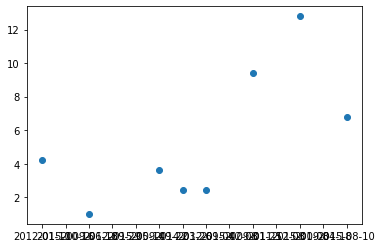

In [237]:
plt.scatter(weather.acq_date[::10000] ,weather.Evaporation[::10000])

In [238]:
weather.Evaporation.max()

145.0

In [239]:
weather

,acq_date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,latitude,longitude
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.1,8.0,NaN,16.9,21.8,No,0.0,No,-36.080477,146.916280
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1007.8,NaN,NaN,17.2,24.3,No,0.0,No,-36.080477,146.916280
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1008.7,NaN,2.0,21.0,23.2,No,0.0,No,-36.080477,146.916280
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1012.8,NaN,NaN,18.1,26.5,No,1.0,No,-36.080477,146.916280
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1006.0,7.0,8.0,17.8,29.7,No,0.2,No,-36.080477,146.916280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,1021.2,NaN,NaN,9.4,20.9,No,0.0,No,-25.345554,131.036961
142189,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,1020.3,NaN,NaN,10.1,22.4,No,0.0,No,-25.345554,131.036961
142190,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,1019.1,NaN,NaN,10.9,24.5,No,0.0,No,-25.345554,131.036961
142191,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,1016.8,NaN,NaN,12.5,26.1,No,0.0,No,-25.345554,131.036961


In [241]:
weather.isna().sum()

acq_date             0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
latitude             0
longitude            0
dtype: int64

In [242]:
#weather = weather.dropna()

In [243]:
weather

,acq_date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow,latitude,longitude
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,1007.1,8.0,NaN,16.9,21.8,No,0.0,No,-36.080477,146.916280
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,1007.8,NaN,NaN,17.2,24.3,No,0.0,No,-36.080477,146.916280
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,1008.7,NaN,2.0,21.0,23.2,No,0.0,No,-36.080477,146.916280
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,1012.8,NaN,NaN,18.1,26.5,No,1.0,No,-36.080477,146.916280
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,1006.0,7.0,8.0,17.8,29.7,No,0.2,No,-36.080477,146.916280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,1021.2,NaN,NaN,9.4,20.9,No,0.0,No,-25.345554,131.036961
142189,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,1020.3,NaN,NaN,10.1,22.4,No,0.0,No,-25.345554,131.036961
142190,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,1019.1,NaN,NaN,10.9,24.5,No,0.0,No,-25.345554,131.036961
142191,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,1016.8,NaN,NaN,12.5,26.1,No,0.0,No,-25.345554,131.036961


In [244]:
weather = weather.drop(['Sunshine'], 1)

In [245]:
weather = weather.drop(['RISK_MM'], 1)

In [246]:
weather.isna().sum()

acq_date             0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
latitude             0
longitude            0
dtype: int64

In [247]:
weather

,acq_date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,latitude,longitude
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,W,44.0,W,WNW,...,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,-36.080477,146.916280
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,WNW,44.0,NNW,WSW,...,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,-36.080477,146.916280
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,WSW,46.0,W,WSW,...,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,-36.080477,146.916280
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NE,24.0,SE,E,...,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,-36.080477,146.916280
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,W,41.0,ENE,NW,...,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,-36.080477,146.916280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,Uluru,3.5,21.8,0.0,NaN,E,31.0,ESE,E,...,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No,-25.345554,131.036961
142189,2017-06-21,Uluru,2.8,23.4,0.0,NaN,E,31.0,SE,ENE,...,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No,-25.345554,131.036961
142190,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NNW,22.0,SE,N,...,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No,-25.345554,131.036961
142191,2017-06-23,Uluru,5.4,26.9,0.0,NaN,N,37.0,SE,WNW,...,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No,-25.345554,131.036961


In [248]:
#weather.to_csv(r'..\Data\Clean\cweather.csv', index=False)

In [249]:
rt_mode = weather['RainToday'].describe().top


In [250]:
weather['RainToday'].fillna(rt_mode, inplace=True)

In [251]:
weather.isnull().sum()

acq_date             0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday            0
RainTomorrow         0
latitude             0
longitude            0
dtype: int64

In [252]:
for col in weather.columns:
    print(col + ' has ' + str(round((weather[col].isnull().sum() / weather.shape[0]) * 100, 2)) + '% missing values')

acq_date has 0.0% missing values
Location has 0.0% missing values
MinTemp has 0.45% missing values
MaxTemp has 0.23% missing values
Rainfall has 0.99% missing values
Evaporation has 42.79% missing values
WindGustDir has 6.56% missing values
WindGustSpeed has 6.52% missing values
WindDir9am has 7.04% missing values
WindDir3pm has 2.66% missing values
WindSpeed9am has 0.95% missing values
WindSpeed3pm has 1.85% missing values
Humidity9am has 1.25% missing values
Humidity3pm has 2.54% missing values
Pressure9am has 9.86% missing values
Pressure3pm has 9.83% missing values
Cloud9am has 37.74% missing values
Cloud3pm has 40.15% missing values
Temp9am has 0.64% missing values
Temp3pm has 1.92% missing values
RainToday has 0.0% missing values
RainTomorrow has 0.0% missing values
latitude has 0.0% missing values
longitude has 0.0% missing values


In [253]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   acq_date       142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   WindGustDir    132863 non-null  object 
 7   WindGustSpeed  132923 non-null  float64
 8   WindDir9am     132180 non-null  object 
 9   WindDir3pm     138415 non-null  object 
 10  WindSpeed9am   140845 non-null  float64
 11  WindSpeed3pm   139563 non-null  float64
 12  Humidity9am    140419 non-null  float64
 13  Humidity3pm    138583 non-null  float64
 14  Pressure9am    128179 non-null  float64
 15  Pressure3pm    128212 non-null  float64
 16  Cloud9am       88536 non-null   float64
 17  Cloud3pm       85099 non-null

In [254]:
weather['acq_date'] = pd.to_datetime(weather['acq_date'])
weather.head()

,acq_date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,latitude,longitude
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,W,44.0,W,WNW,...,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,-36.080477,146.91628
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,WNW,44.0,NNW,WSW,...,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,-36.080477,146.91628
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,WSW,46.0,W,WSW,...,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,-36.080477,146.91628
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NE,24.0,SE,E,...,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,-36.080477,146.91628
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,W,41.0,ENE,NW,...,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,-36.080477,146.91628


In [255]:
month = [d.month for d in weather['acq_date']]
weather['Month'] = month

In [256]:
weather.head()

,acq_date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,latitude,longitude,Month
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,W,44.0,W,WNW,...,1007.1,8.0,NaN,16.9,21.8,No,No,-36.080477,146.91628,12
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,WNW,44.0,NNW,WSW,...,1007.8,NaN,NaN,17.2,24.3,No,No,-36.080477,146.91628,12
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,WSW,46.0,W,WSW,...,1008.7,NaN,2.0,21.0,23.2,No,No,-36.080477,146.91628,12
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NE,24.0,SE,E,...,1012.8,NaN,NaN,18.1,26.5,No,No,-36.080477,146.91628,12
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,W,41.0,ENE,NW,...,1006.0,7.0,8.0,17.8,29.7,No,No,-36.080477,146.91628,12


In [257]:
weather['Rainfall'].fillna(0, inplace=True)

In [258]:
weather.isnull().sum()

acq_date             0
Location             0
MinTemp            637
MaxTemp            322
Rainfall             0
Evaporation      60843
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday            0
RainTomorrow         0
latitude             0
longitude            0
Month                0
dtype: int64

In [259]:
rt_mode = weather['RainToday'].describe().top
weather['RainToday'].fillna(rt_mode, inplace=True)

In [260]:
rain.isnull().sum()

Rain ID                               0
Date/Time                             0
Nearest town                          2
State                                 0
Latitude                              0
Longitude                             0
Severity confidence description      41
Intense precipitation amount          0
Intense precipitation period          0
Total precipitation                   0
Total precipitation duration          0
Water course                       3245
Damage total                       2957
Insurance payout                   2957
Number of deaths                   2957
Number of injuries                 2957
Unnamed: 16                        3466
dtype: int64

In [261]:
weather['Cloud9am'].fillna(0, inplace=True)
weather['Cloud3pm'].fillna(0, inplace=True)

In [262]:
weather['Evaporation'].fillna(0, inplace=True)

In [263]:
weather.isna().sum()

acq_date             0
Location             0
MinTemp            637
MaxTemp            322
Rainfall             0
Evaporation          0
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am             0
Cloud3pm             0
Temp9am            904
Temp3pm           2726
RainToday            0
RainTomorrow         0
latitude             0
longitude            0
Month                0
dtype: int64

In [264]:
top = weather['WindGustDir'].describe().top

In [265]:
weather['WindGustDir'].fillna(top, inplace=True)

In [266]:
weather.isna().sum()

acq_date             0
Location             0
MinTemp            637
MaxTemp            322
Rainfall             0
Evaporation          0
WindGustDir          0
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am             0
Cloud3pm             0
Temp9am            904
Temp3pm           2726
RainToday            0
RainTomorrow         0
latitude             0
longitude            0
Month                0
dtype: int64

In [267]:
# for whole dataframe
#weather = weather.replace(np.nan, 0)
weather

,acq_date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,latitude,longitude,Month
0,2008-12-01,Albury,13.4,22.9,0.6,0.0,W,44.0,W,WNW,...,1007.1,8.0,0.0,16.9,21.8,No,No,-36.080477,146.916280,12
1,2008-12-02,Albury,7.4,25.1,0.0,0.0,WNW,44.0,NNW,WSW,...,1007.8,0.0,0.0,17.2,24.3,No,No,-36.080477,146.916280,12
2,2008-12-03,Albury,12.9,25.7,0.0,0.0,WSW,46.0,W,WSW,...,1008.7,0.0,2.0,21.0,23.2,No,No,-36.080477,146.916280,12
3,2008-12-04,Albury,9.2,28.0,0.0,0.0,NE,24.0,SE,E,...,1012.8,0.0,0.0,18.1,26.5,No,No,-36.080477,146.916280,12
4,2008-12-05,Albury,17.5,32.3,1.0,0.0,W,41.0,ENE,NW,...,1006.0,7.0,8.0,17.8,29.7,No,No,-36.080477,146.916280,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,Uluru,3.5,21.8,0.0,0.0,E,31.0,ESE,E,...,1021.2,0.0,0.0,9.4,20.9,No,No,-25.345554,131.036961,6
142189,2017-06-21,Uluru,2.8,23.4,0.0,0.0,E,31.0,SE,ENE,...,1020.3,0.0,0.0,10.1,22.4,No,No,-25.345554,131.036961,6
142190,2017-06-22,Uluru,3.6,25.3,0.0,0.0,NNW,22.0,SE,N,...,1019.1,0.0,0.0,10.9,24.5,No,No,-25.345554,131.036961,6
142191,2017-06-23,Uluru,5.4,26.9,0.0,0.0,N,37.0,SE,WNW,...,1016.8,0.0,0.0,12.5,26.1,No,No,-25.345554,131.036961,6


In [272]:
weather.Evaporation.describe()

count    142193.000000
mean          3.129340
std           4.166674
min           0.000000
25%           0.000000
50%           1.600000
75%           5.400000
max         145.000000
Name: Evaporation, dtype: float64

In [273]:
weather.keys()

Index(['acq_date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'latitude', 'longitude',
       'Month'],
      dtype='object')

In [277]:
weather[['Humidity3pm','Temp3pm','Temp9am','MinTemp', 'MaxTemp']] = weather[['Humidity3pm','Temp3pm','Temp9am','MinTemp', 'MaxTemp']].fillna(0).astype(float)

In [278]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   acq_date       142193 non-null  datetime64[ns]
 1   Location       142193 non-null  object        
 2   MinTemp        142193 non-null  float64       
 3   MaxTemp        142193 non-null  float64       
 4   Rainfall       142193 non-null  float64       
 5   Evaporation    142193 non-null  float64       
 6   WindGustDir    142193 non-null  object        
 7   WindGustSpeed  132923 non-null  float64       
 8   WindDir9am     132180 non-null  object        
 9   WindDir3pm     138415 non-null  object        
 10  WindSpeed9am   140845 non-null  float64       
 11  WindSpeed3pm   139563 non-null  float64       
 12  Humidity9am    140419 non-null  float64       
 13  Humidity3pm    142193 non-null  float64       
 14  Pressure9am    128179 non-null  float64       
 15  

In [280]:
weather[['WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm']] = weather[['WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm']].fillna(0).astype(float)

In [290]:
weather[['WindGustDir', 'WindDir9am', 'WindDir3pm']] = weather[['WindGustDir', 'WindDir9am', 'WindDir3pm']].fillna(0)

In [291]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   acq_date       142193 non-null  datetime64[ns]
 1   Location       142193 non-null  object        
 2   MinTemp        142193 non-null  float64       
 3   MaxTemp        142193 non-null  float64       
 4   Rainfall       142193 non-null  float64       
 5   Evaporation    142193 non-null  float64       
 6   WindGustDir    142193 non-null  object        
 7   WindGustSpeed  142193 non-null  float64       
 8   WindDir9am     142193 non-null  object        
 9   WindDir3pm     142193 non-null  object        
 10  WindSpeed9am   142193 non-null  float64       
 11  WindSpeed3pm   142193 non-null  float64       
 12  Humidity9am    142193 non-null  float64       
 13  Humidity3pm    142193 non-null  float64       
 14  Pressure9am    142193 non-null  float64       
 15  

In [ ]:
weather= get_state(weather)

In [293]:
weather.to_csv(r'..\Data\Clean\cweather.csv', index=False)